In [19]:
import os
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from datetime import datetime
import csv
import pickle
from joblib import dump, load

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
FOLDER_PATH = "F:\\user\\Google Drive\\Catherning Folder\\THU\\Thesis\\Work\\Recipe datasets\\cuisine_classification"

FILES = ["random","cluster_centroid","full"]
file = FILES[2]

In [3]:
date = datetime.now().strftime("%m-%d-%H-%M")
RESULTS_FOLDER = os.path.join(os.getcwd(),"results",f"ML_{date}_{file}")
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [4]:
results_file = os.path.join(RESULTS_FOLDER,"results.csv")
with open(results_file,"w", newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(["model","best parameters","best f1 train score","threshold","proba score","accuracy","balanced_accuracy","precision","recall","f1_score"])

In [5]:
df_train = pd.read_pickle(os.path.join(FOLDER_PATH, file+"_data.pkl"))

In [6]:
df_train['cuisine'].value_counts()

NorthAmerican       54022
SouthernEuropean     8963
LatinAmerican        6347
WesternEuropean      4243
Asian                3144
EastAsian            2788
SouthAsian           2078
SoutheastAsian        805
MiddleEastern         645
EasternEuropean       381
African               363
NorthernEuropean      250
Name: cuisine, dtype: int64

In [7]:
len(df_train)

84029

In [8]:
cv = CountVectorizer()
X = cv.fit_transform(df_train['all_ingredients'].values)

In [9]:
df_train['all_ingredients'].values

array(['baby_bella_mushroom_sliced;arborio_rice;olive_oil;butter;shallot_minced;white_wine;fat_free_chicken_stock_;salt_pepper;salt_pepper;grated_parmesan_cheese;chopped_parsley',
       'garlic;extra-virgin_olive_oil_divided;madeira_divided;unsalted_chicken_stock_divided;dried_porcini_mushroom_;chopped_onion;thinly_sliced_cremini_mushroom_;thinly_sliced_shiitake_mushroom_cap_;uncooked_arborio_rice;parmesan_cheese_grated_;kosher_salt;freshly_ground_black_pepper;chopped_fresh_sage;sage_',
       'garlic_halved;cooking_spray;peeled_red_potato_;butter_melted;salt;black_pepper;shredded_gruyere_cheese;fat-free_milk',
       ..., 'vegetable;olive_oil;egg;cheese;wheat',
       'tomato;clam;celery;black_pepper;parsley;macaroni',
       'milk;bacon;egg;cream;cheese;onion;black_pepper;parsley;macaroni'],
      dtype=object)

In [10]:
dump(cv.vocabulary_,"scikit_vocab.joblib")

['scikit_vocab.joblib']

## Processing

In [11]:
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)
print(enc.classes_)
enc.classes_.shape

['African' 'Asian' 'EastAsian' 'EasternEuropean' 'LatinAmerican'
 'MiddleEastern' 'NorthAmerican' 'NorthernEuropean' 'SouthAsian'
 'SoutheastAsian' 'SouthernEuropean' 'WesternEuropean']


(12,)

In [12]:
dump(enc,"scikit_vocab_cuisine.joblib")

['scikit_vocab_cuisine.joblib']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 72,
 1: 629,
 2: 558,
 3: 76,
 4: 1269,
 5: 129,
 6: 10804,
 7: 50,
 8: 416,
 9: 161,
 10: 1793,
 11: 849}

## Results methods

In [14]:
# For future predictions, get proba and only classifies if proba is higher than threshold
def threshold_classification(clf,X_test,y_test,threshold=0.85):
    y_pred_prob = clf.predict_proba(X_test)
    max_prob = y_pred_prob.max(axis=1)
    y_pred = y_pred_prob.argmax(axis=1)

    to_del = np.argwhere(max_prob < threshold).T[0]

    partial_y_pred = np.delete(y_pred,to_del)
    partial_y_test = np.delete(y_test,to_del)

    proba_score = accuracy_score(partial_y_test,partial_y_pred)
    
    return proba_score

In [22]:
def confusion_matrix_plot(y_pred,y_labels,save_folder,name):
    fig = plt.figure(figsize=(10, 10))

    cm = confusion_matrix(y_labels, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest')
    plt.title(name+" Confusion matrix")
    plt.colorbar(shrink=0.3)
    cuisines = df_train['cuisine'].value_counts().index
    tick_marks = np.arange(len(cuisines))
    plt.xticks(tick_marks, enc.classes_, rotation=90)
    plt.yticks(tick_marks, enc.classes_)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #fig.show()
    
    fig.savefig(os.path.join(save_folder, '{}.png'.format(name)), dpi=fig.dpi)

In [23]:
def classification_report_to_csv(y_test,y_pred,enc,model_name,save_folder):
    report = classification_report(y_test, y_pred, labels=[i for i in range(enc.classes_.shape[0])], target_names=enc.classes_, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(os.path.join(save_folder,f'{model_name}.csv'))

In [69]:
def trainEvalModel(model,model_name,parameters,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,scoring = 'f1_weighted',threshold = 0.95):

    try:
        clf = load(os.path.join("ml_results","{}.joblib".format(model_name)))
        print("Model loaded")
    except FileNotFoundError:
        if model_name=="Linear SVC":
            clf = CalibratedClassifierCV(model,method="sigmoid",cv=4)
        else:
            clf = GridSearchCV(model, parameters, cv=4,scoring=scoring)

        clf.fit(X_train, y_train)
        dump(clf,os.path.join("ml_results","{}.joblib".format(model_name)))
        
    try:
        estimator = clf.best_estimator_ 
    except AttributeError: 
        estimator = clf.calibrated_classifiers_[0]
    print(estimator)
    
    # Eval
    try:
        best_score = clf.best_score_
        
    except AttributeError:
        best_score = clf.score(X_train,y_train)
    print("Best {} score = {}".format(scoring,best_score))

    test_score = clf.score(X_test, y_test)
    print("Best {} test score = {}".format(scoring,test_score))
    
    proba_score = threshold_classification(clf,X_test,y_test,threshold=threshold)
    print("Best {} {} confidence test score = {}".format(scoring,threshold,proba_score))
    
    # Saving data 
    y_pred = clf.predict(X_test)
    confusion_matrix_plot(y_pred, y_test,RESULTS_FOLDER,model_name)
    
    classification_report_to_csv(y_test,y_pred,enc,model_name,RESULTS_FOLDER)
    
    res=[accuracy_score(y_test,y_pred),balanced_accuracy_score(y_test,y_pred),precision_score(y_test,y_pred,average='weighted'),recall_score(y_test,y_pred,average='weighted'),f1_score(y_test,y_pred,average='weighted')]
    print(res)
    
    with open(results_file,"a", newline='') as f:
        writer = csv.writer(f, delimiter=';')
        writer.writerow([model_name,estimator,best_score,threshold,proba_score]+res)


# Logistic Regression

Model loaded
LogisticRegression(C=0.7, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=True)
Best f1_weighted score = 0.7412316428423366
Best f1_weighted test score = 0.7453957322535449
Best f1_weighted 0.95 confidence test score = 0.968
[0.7248601689872665, 0.5671324735879839, 0.7743042685071282, 0.7248601689872665, 0.7453957322535449]


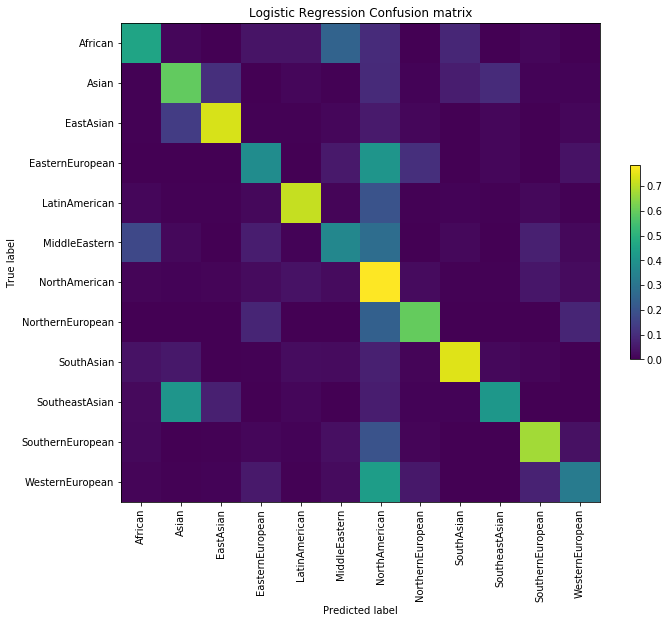

In [56]:
#parameters = {'C':[0.4,0.5,0.6,0.7],
#             'solver' : ('newton-cg', 'liblinear')}
parameters = {'C':[0.7],
              'solver' : ('liblinear',)}

logistic = LogisticRegression(class_weight="balanced",multi_class="auto",max_iter=150,warm_start=True)

trainEvalModel(logistic,"Logistic Regression",parameters)

# SVM

Model loaded
SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=True)
Best f1_weighted score = 0.7253557887346509
Best f1_weighted test score = 0.7312897935375617
Best f1_weighted 0.95 confidence test score = 0.968421052631579
[0.7072474116387004, 0.5352913635731397, 0.7646495599131724, 0.7072474116387004, 0.7312897935375617]


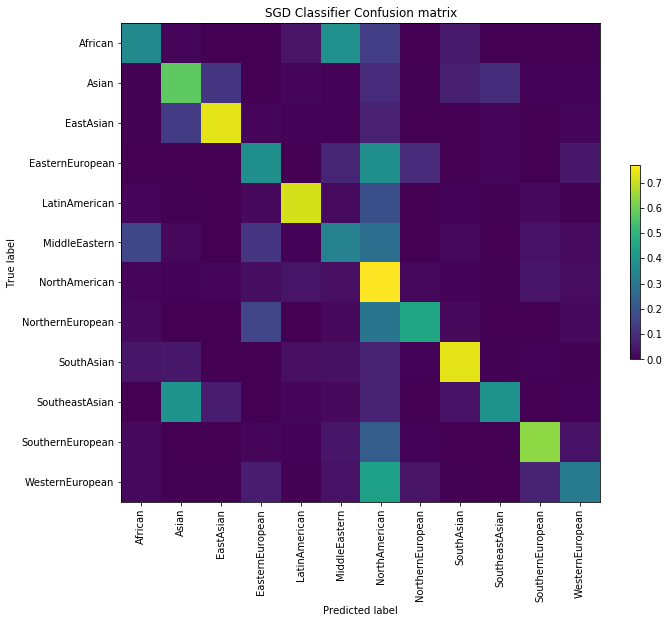

In [57]:
parameters = {'loss':("log",)}#('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')}

sgd = SGDClassifier(class_weight="balanced",early_stopping=True,warm_start=True)

trainEvalModel(sgd,"SGD Classifier",parameters)

# Naive Bayes

Model loaded
ComplementNB(alpha=0.2, class_prior=None, fit_prior=True, norm=False)
Best f1_weighted score = 0.711075176163356
Best f1_weighted test score = 0.712419226976684
Best f1_weighted 0.95 confidence test score = 0.9036564132327336


C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\TEMP.PKAPRIME.000.001\AppData\Local\conda\conda\envs\recipe_env\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7283113173866477, 0.3636924953613092, 0.7094922521165195, 0.7283113173866477, 0.712419226976684]


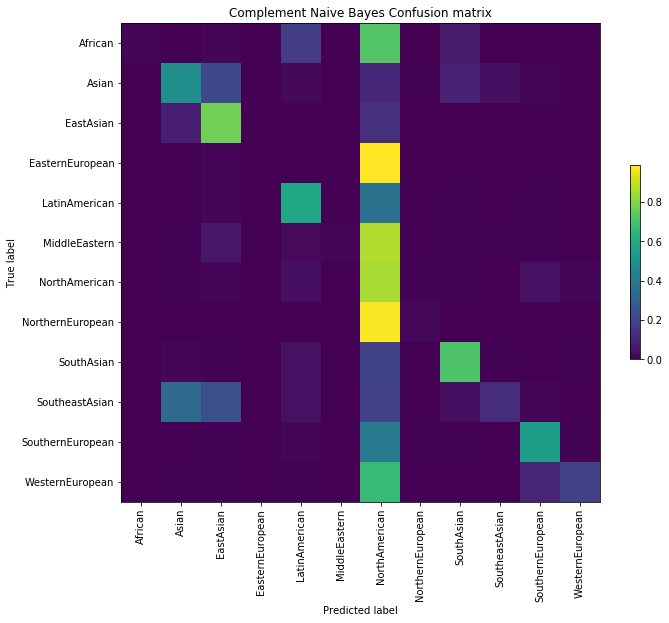

In [58]:
parameters = {'alpha':[0.2,]}#[i*0.2 for i in range(1,5)]}

trainEvalModel(ComplementNB(),"Complement Naive Bayes",parameters)

# Decision Tree 

Model loaded
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')
Best f1_weighted score = 0.6826545612764163
Best f1_weighted test score = 0.690603110021478
Best f1_weighted 0.95 confidence test score = 0.7000756906774316
[0.6938593359514459, 0.3720173298209542, 0.6878442235733151, 0.6938593359514459, 0.690603110021478]


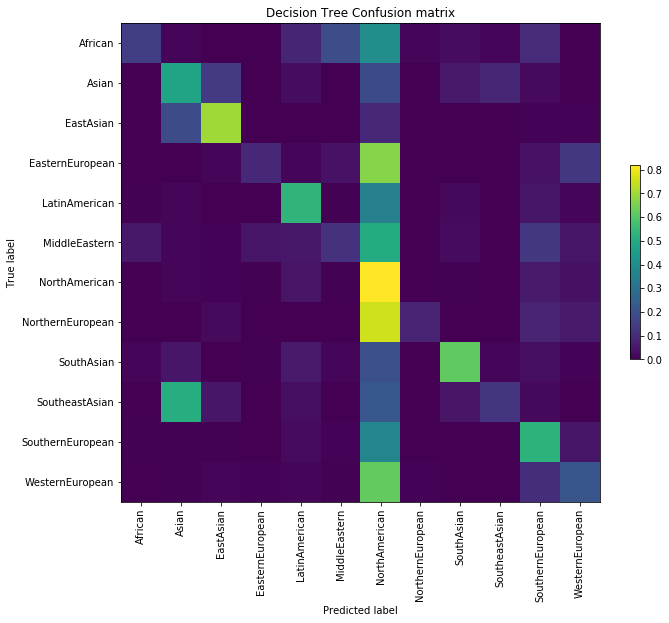

In [59]:
parameters = {"criterion":["gini",],#"entropy"],
            "splitter":["best","random"]}

trainEvalModel(DecisionTreeClassifier(),"Decision Tree",parameters)

# Extra Tree 

Model loaded
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Best f1_weighted score = 0.7290956746620141
Best f1_weighted test score = 0.7369257056846035
Best f1_weighted 0.95 confidence test score = 0.8663012392755005
[0.767642508627871, 0.349466024256954, 0.7441893408195408, 0.767642508627871, 0.7369257056846035]


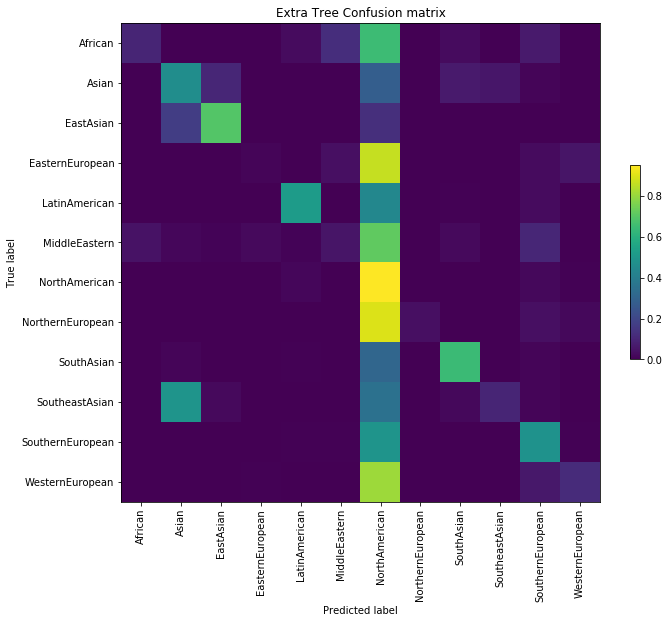

In [60]:
parameters = {"criterion":["gini",]}#"entropy"]}

trainEvalModel(ExtraTreesClassifier(),"Extra Tree",parameters)

## KNeighbors Classifier

Model loaded
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')
Best f1_weighted score = 0.6334611211218844
Best f1_weighted test score = 0.6418931908725791
Best f1_weighted 0.95 confidence test score = 0.8083077597544936
[0.6689277638938474, 0.27600006763140633, 0.6354373429833926, 0.6689277638938474, 0.6418931908725791]


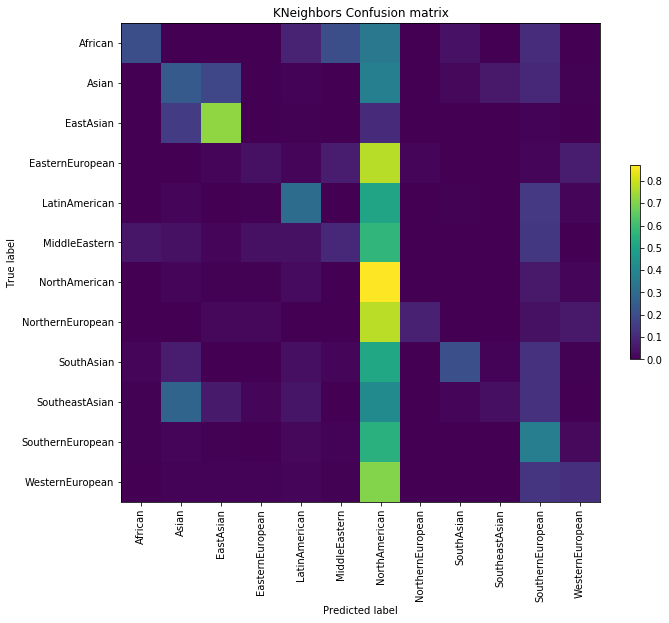

In [61]:
parameters = {"n_neighbors":[3,],#i for i in range(3,7)],
            "weights":["distance",]}#"uniform","distance"]}

trainEvalModel(KNeighborsClassifier(),"KNeighbors",parameters)

## Linear SVC

Model loaded
Best f1_weighted score = 0.8509587492376122
Best f1_weighted test score = 0.779245507556825
Best f1_weighted 0.95 confidence test score = 0.9786036036036037
[0.779245507556825, 0.3739362535466293, 0.7688162732558181, 0.779245507556825, 0.7519958808963846]


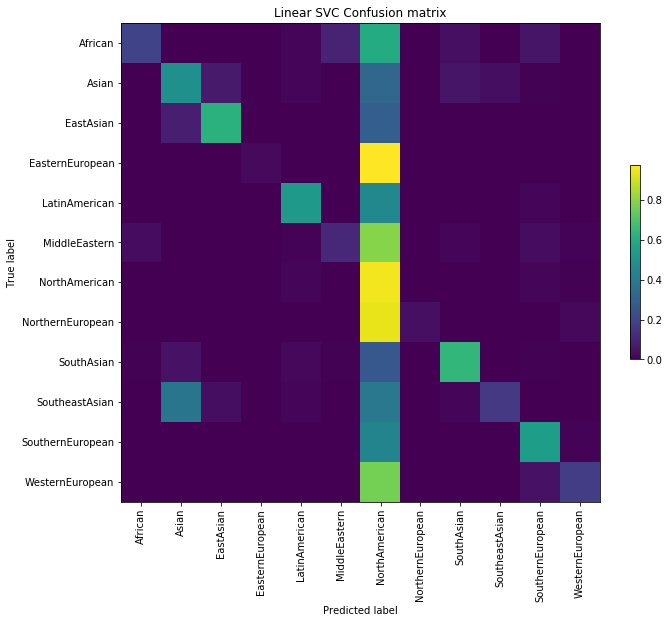

In [70]:
parameters = {"penalty":["l2",],#"l1"],
             "dual":[False,True],
             "C":[1]}#i for i in range(1,5)]}

trainEvalModel(LinearSVC(),"Linear SVC",parameters)

# Random Forest

much slower and a bit worse

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
Best f1_weighted score = 0.6993923568786998
Best f1_weighted test score = 0.7133482374584933
Best f1_weighted 0.95 confidence test score = 0.9664195377235063
[0.7436034749494228, 0.33568770516598795, 0.717516728351616, 0.7436034749494228, 0.7133482374584933]


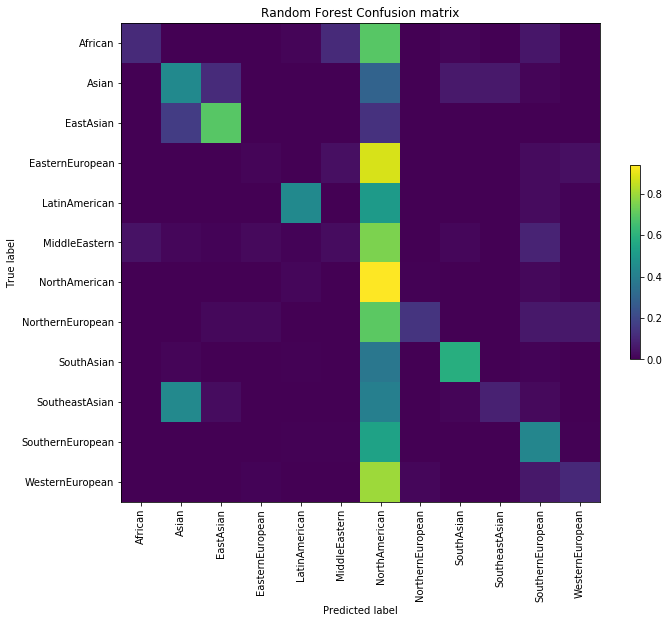

In [72]:
parameters = {'max_depth':(None,)}#3,5,8)}

rf = RandomForestClassifier(n_estimators=50, random_state=123,class_weight="balanced")

trainEvalModel(rf,"Random Forest",parameters)

# NN eval